In [104]:
# Imports
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

In [105]:


# Create the Tkinter root widget
# root = tk.Tk()
# root.withdraw()  # Hide the main window

# # Ask the user to select a file
# dyno_file_path = filedialog.askopenfilename(
#     title="Select the dyno run .txt file",
#     filetypes=[("All files", "*.*")],
#     initialdir="/",
#     message="Please select the dyno run .txt."
# )
# # Ask the user to select a file
# car_log_file_path = filedialog.askopenfilename(
#     title="Select the car log .csv file",
#     filetypes=[("All files", "*.*")],
#     initialdir="/",
#     message="Please select the car log csv."
# )
# dyno_file_path
dyno_file_path = "4-26-23_power_run.txt"
car_log_path = r"C:\Users\Matthew Samson\Documents\formula\4-26-2023_dyno_and_regen\parsed-data\parseddata0003.CSV"
dyno_file_path="your_file_reformatted.txt"
car_log_path=r"C:\Users\Matthew Samson\Documents\formula\228hv\parsed-data\parsedMDY_3-3-2024_HMS_3-58-56.CSV"


In [106]:
# # Read the file
# with open('dynoruns\DJDataExport_DYNORUN_015.txt', 'r') as file:
# # Read the file
#     lines = file.readlines()

# # Remove leading and trailing spaces, split columns, and exclude lines with 'N/A'
# formatted_lines = [line.strip().split() for line in lines if 'N/A' not in line]

# # Reformat the lines with tab delimiter
# formatted_text = '\n'.join(['\t'.join(line) for line in formatted_lines])

# # Write the reformatted text back to the file
# with open('your_file_reformatted.txt', 'w') as file:
#     file.write(formatted_text)



In [107]:
# Calculate some constants 
gear_tooth_count_motor = 10  # KS6e front sprocket
gear_tooth_count_wheel = 30  # KS6e rear sprocket

dyno_tire_diameter = 20.5 # ish inches 
tire_dims = [17,18,19,20]
normal_tire_diameter = 18 # ish inches
tire_diameter = dyno_tire_diameter # set to the right tire size when plotting

gear_ratio = gear_tooth_count_wheel / gear_tooth_count_motor

# Calculate wheel circumference
wheel_circumference = tire_diameter * 3.141592653589793  # Pi
wheel_circums_varied = []
for dim in tire_dims:
    wheel_circums_varied.append(dim*3.141592653589793)
wheel_circums_varied


[53.40707511102649, 56.548667764616276, 59.690260418206066, 62.83185307179586]

In [108]:
# open dyno run file
dyno_run_df = pd.read_csv(dyno_file_path,delimiter="\t")
# drop shit rows
dynorun = dyno_run_df[dyno_run_df["s"]>=0]
# dynorun = dyno_run_df[dyno_run_df["hp"]>=0]
try:
    dynorun.drop(dynorun.columns[[0,4]],axis=1,inplace=True) # remove bs columns
except:
    pass
del(dyno_run_df)
dynorun["kw"] = dynorun['hp']/1.341 # add KW column
dynorun["wheel_rpm"] = dynorun["mph"] / ((wheel_circumference * 60)/63360 )
list_of_varied_dims_rpms=[]
for index,circum in enumerate(tire_dims):
    name = "wheel_rpm_"+str(circum)
    dynorun[name] = dynorun["mph"] / ((circum * 3.141592653589793 * 60)/63360 )
    list_of_varied_dims_rpms.append(name)
    
print(list_of_varied_dims_rpms)
dynorun["wheel_torque"] = (9548.8 * dynorun["kw"])/dynorun["wheel_rpm"]

list_of_varied_wtrq = []
for index,rpm in enumerate(list_of_varied_dims_rpms):
    wtrqname = "wheel_torque_"+str(tire_dims[index])
    dynorun[wtrqname]=(9548.8 * dynorun["kw"])/dynorun[rpm]
    list_of_varied_wtrq.append(wtrqname)
    
dynorun["motor_rpm"]=dynorun["wheel_rpm"]*gear_ratio

for index,rpm in enumerate(list_of_varied_dims_rpms):
    colname = "motor_rpm_" +str(tire_dims[index])
    dynorun[colname]=dynorun[rpm]*gear_ratio
    
dynorun["motor_torque"] = dynorun["wheel_torque"] / gear_ratio

for index,trq in enumerate(list_of_varied_wtrq):
    colname = "motor_torque_" +str(tire_dims[index])
    dynorun[colname]=dynorun[trq]/gear_ratio
    
print("dynorun MAXES:")
dynorun.max()

['wheel_rpm_17', 'wheel_rpm_18', 'wheel_rpm_19', 'wheel_rpm_20']
dynorun MAXES:


s                    51.940000
mph                  73.430000
hp                   31.330000
kw                   23.363162
wheel_rpm          1204.020032
wheel_rpm_17       1451.906509
wheel_rpm_18       1371.245037
wheel_rpm_19       1299.074245
wheel_rpm_20       1234.120533
wheel_torque        418.296234
wheel_torque_17     346.879804
wheel_torque_18     367.284498
wheel_torque_19     387.689193
wheel_torque_20     408.093887
motor_rpm          3612.060096
motor_rpm_17       4355.719528
motor_rpm_18       4113.735110
motor_rpm_19       3897.222736
motor_rpm_20       3702.361599
motor_torque        139.432078
motor_torque_17     115.626601
motor_torque_18     122.428166
motor_torque_19     129.229731
motor_torque_20     136.031296
dtype: float64

In [109]:
# load electrical log
vehicle_log = pd.read_csv(car_log_path)
# remove df cols we dont care about
vehicle_log = vehicle_log[["Time","D1_Commanded_Torque","D2_Torque_Feedback","D2_Motor_Speed","Pack_Current","Pack_Summed_Voltage"]]
# cancer time
from torque_log_analysis import resample_data,drop_rows_from_df
vehicle_log = resample_data(vehicle_log,"Time")
vehicle_log = drop_rows_from_df(vehicle_log,"D1_Commanded_Torque",1,400)

vehicle_log = drop_rows_from_df(vehicle_log,"D2_Motor_Speed",10,7000)
# get a power column to compare with dyno
vehicle_log["kw"] = vehicle_log["Pack_Current"] * vehicle_log["Pack_Summed_Voltage"] / 1000
vehicle_log.max()


D1_Commanded_Torque     199.920000
D2_Torque_Feedback      139.575000
D2_Motor_Speed         4053.000000
Pack_Current            175.966667
Pack_Summed_Voltage     245.215395
kw                       30.780651
dtype: float64

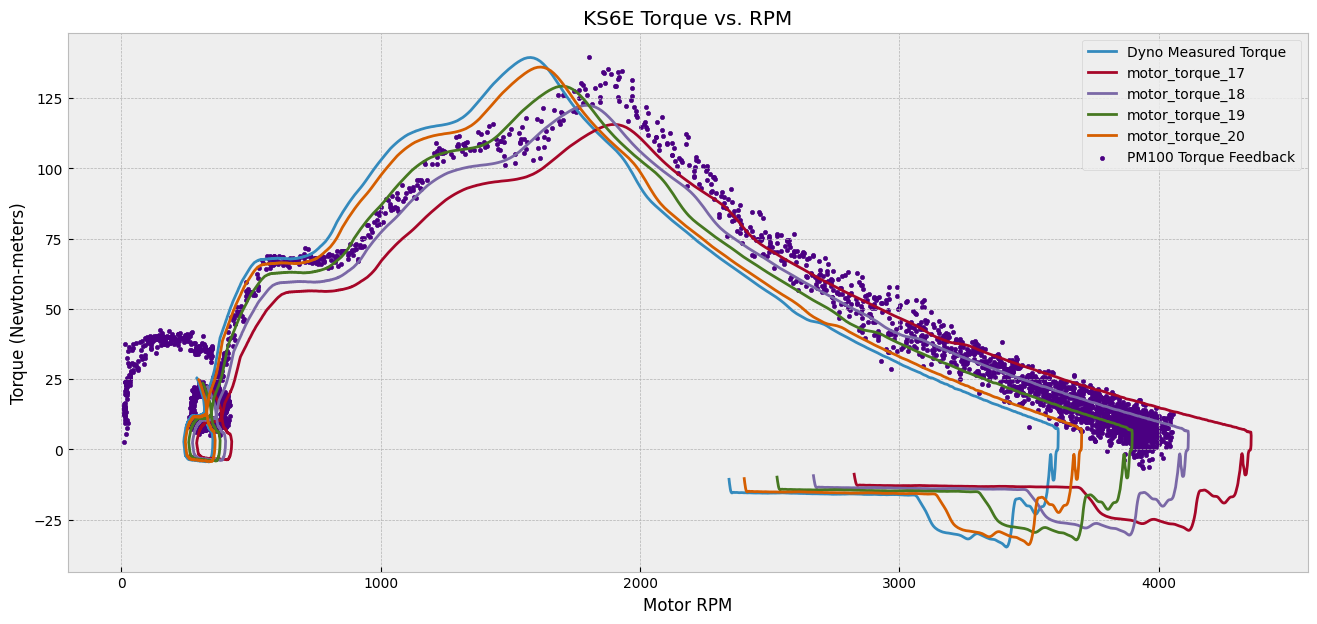

In [110]:
# plot torques and rpms to compare
plt.style.use('bmh')
plt.figure(figsize=(16,7))
plt.plot(dynorun["motor_rpm"],dynorun["motor_torque"],label="Dyno Measured Torque")

for dim in tire_dims:
    plt.plot(dynorun["motor_rpm_"+str(dim)],dynorun["motor_torque_"+str(dim)],label="motor_torque_"+str(dim))
        
plt.scatter(vehicle_log["D2_Motor_Speed"],vehicle_log["D2_Torque_Feedback"],marker='.',color='indigo',label="PM100 Torque Feedback")
plt.xlabel("Motor RPM")
plt.ylabel("Torque (Newton-meters)")
plt.legend()
plt.title("KS6E Torque vs. RPM")
plt.show()

In [111]:
# Attempt to sync dyno and car log
dynorun["s"]=pd.to_datetime(dynorun["s"],unit="s")
vehlogstart = vehicle_log.index.min()
dynologstart = dynorun["s"].min()
timeoffset = vehlogstart-dynologstart
timeoffset
# this offset has to be manually adjusted lol :(
runoffset = pd.tseries.offsets.DateOffset(seconds=2,milliseconds=800)
dynorun["s"] = dynorun["s"]+timeoffset + runoffset
dynorun


,s,mph,hp,kw,wheel_rpm,wheel_rpm_17,wheel_rpm_18,wheel_rpm_19,wheel_rpm_20,wheel_torque,...,motor_rpm,motor_rpm_17,motor_rpm_18,motor_rpm_19,motor_rpm_20,motor_torque,motor_torque_17,motor_torque_18,motor_torque_19,motor_torque_20
0,2024-03-03 04:00:38.870,5.93,1.04,0.775541,97.233267,117.251881,110.737887,104.909577,99.664099,76.162025,...,291.699801,351.755642,332.213662,314.728732,298.992296,25.387342,21.052917,22.291324,23.529731,24.768138
1,2024-03-03 04:00:38.880,5.94,1.04,0.775541,97.397235,117.449607,110.924629,105.086491,99.832166,76.033806,...,292.191706,352.348822,332.773887,315.259472,299.496499,25.344602,21.017475,22.253797,23.490119,24.726441
2,2024-03-03 04:00:38.890,5.97,1.03,0.768084,97.889141,118.042787,111.484855,105.617231,100.336369,74.924306,...,293.667422,354.128361,334.454564,316.851692,301.009107,24.974769,20.710784,21.929065,23.147347,24.365628
3,2024-03-03 04:00:38.900,5.98,1.03,0.768084,98.053109,118.240514,111.671596,105.794144,100.504437,74.799014,...,294.159327,354.721541,335.014789,317.382432,301.513310,24.933005,20.676150,21.892394,23.108639,24.324883
4,2024-03-03 04:00:38.910,6.02,1.01,0.753169,98.708983,119.031420,112.418564,106.501797,101.176707,72.859254,...,296.126948,357.094261,337.255691,319.505391,303.530122,24.286418,20.139956,21.324660,22.509363,23.694066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,2024-03-03 04:01:23.090,47.70,-4.36,-3.251305,782.129314,943.155938,890.758385,843.876365,801.682547,-39.694281,...,2346.387942,2829.467813,2672.275156,2531.629096,2405.047641,-13.231427,-10.972403,-11.617838,-12.263274,-12.908709
3619,2024-03-03 04:01:23.100,47.69,-4.25,-3.169277,781.965346,942.958211,890.571644,843.699452,801.514479,-38.700934,...,2345.896037,2828.874633,2671.714931,2531.098356,2404.543438,-12.900311,-10.697819,-11.327103,-11.956386,-12.585669
3620,2024-03-03 04:01:23.110,47.67,-4.02,-2.997763,781.637409,942.562758,890.198160,843.345625,801.178344,-36.621888,...,2344.912227,2827.688273,2670.594480,2530.036876,2403.535032,-12.207296,-10.123124,-10.718602,-11.314079,-11.909557
3621,2024-03-03 04:01:23.120,47.66,-3.89,-2.900820,781.473440,942.365031,890.011418,843.168712,801.010276,-35.445034,...,2344.420321,2827.095093,2670.034255,2529.506136,2403.030829,-11.815011,-9.797814,-10.374156,-10.950498,-11.526840


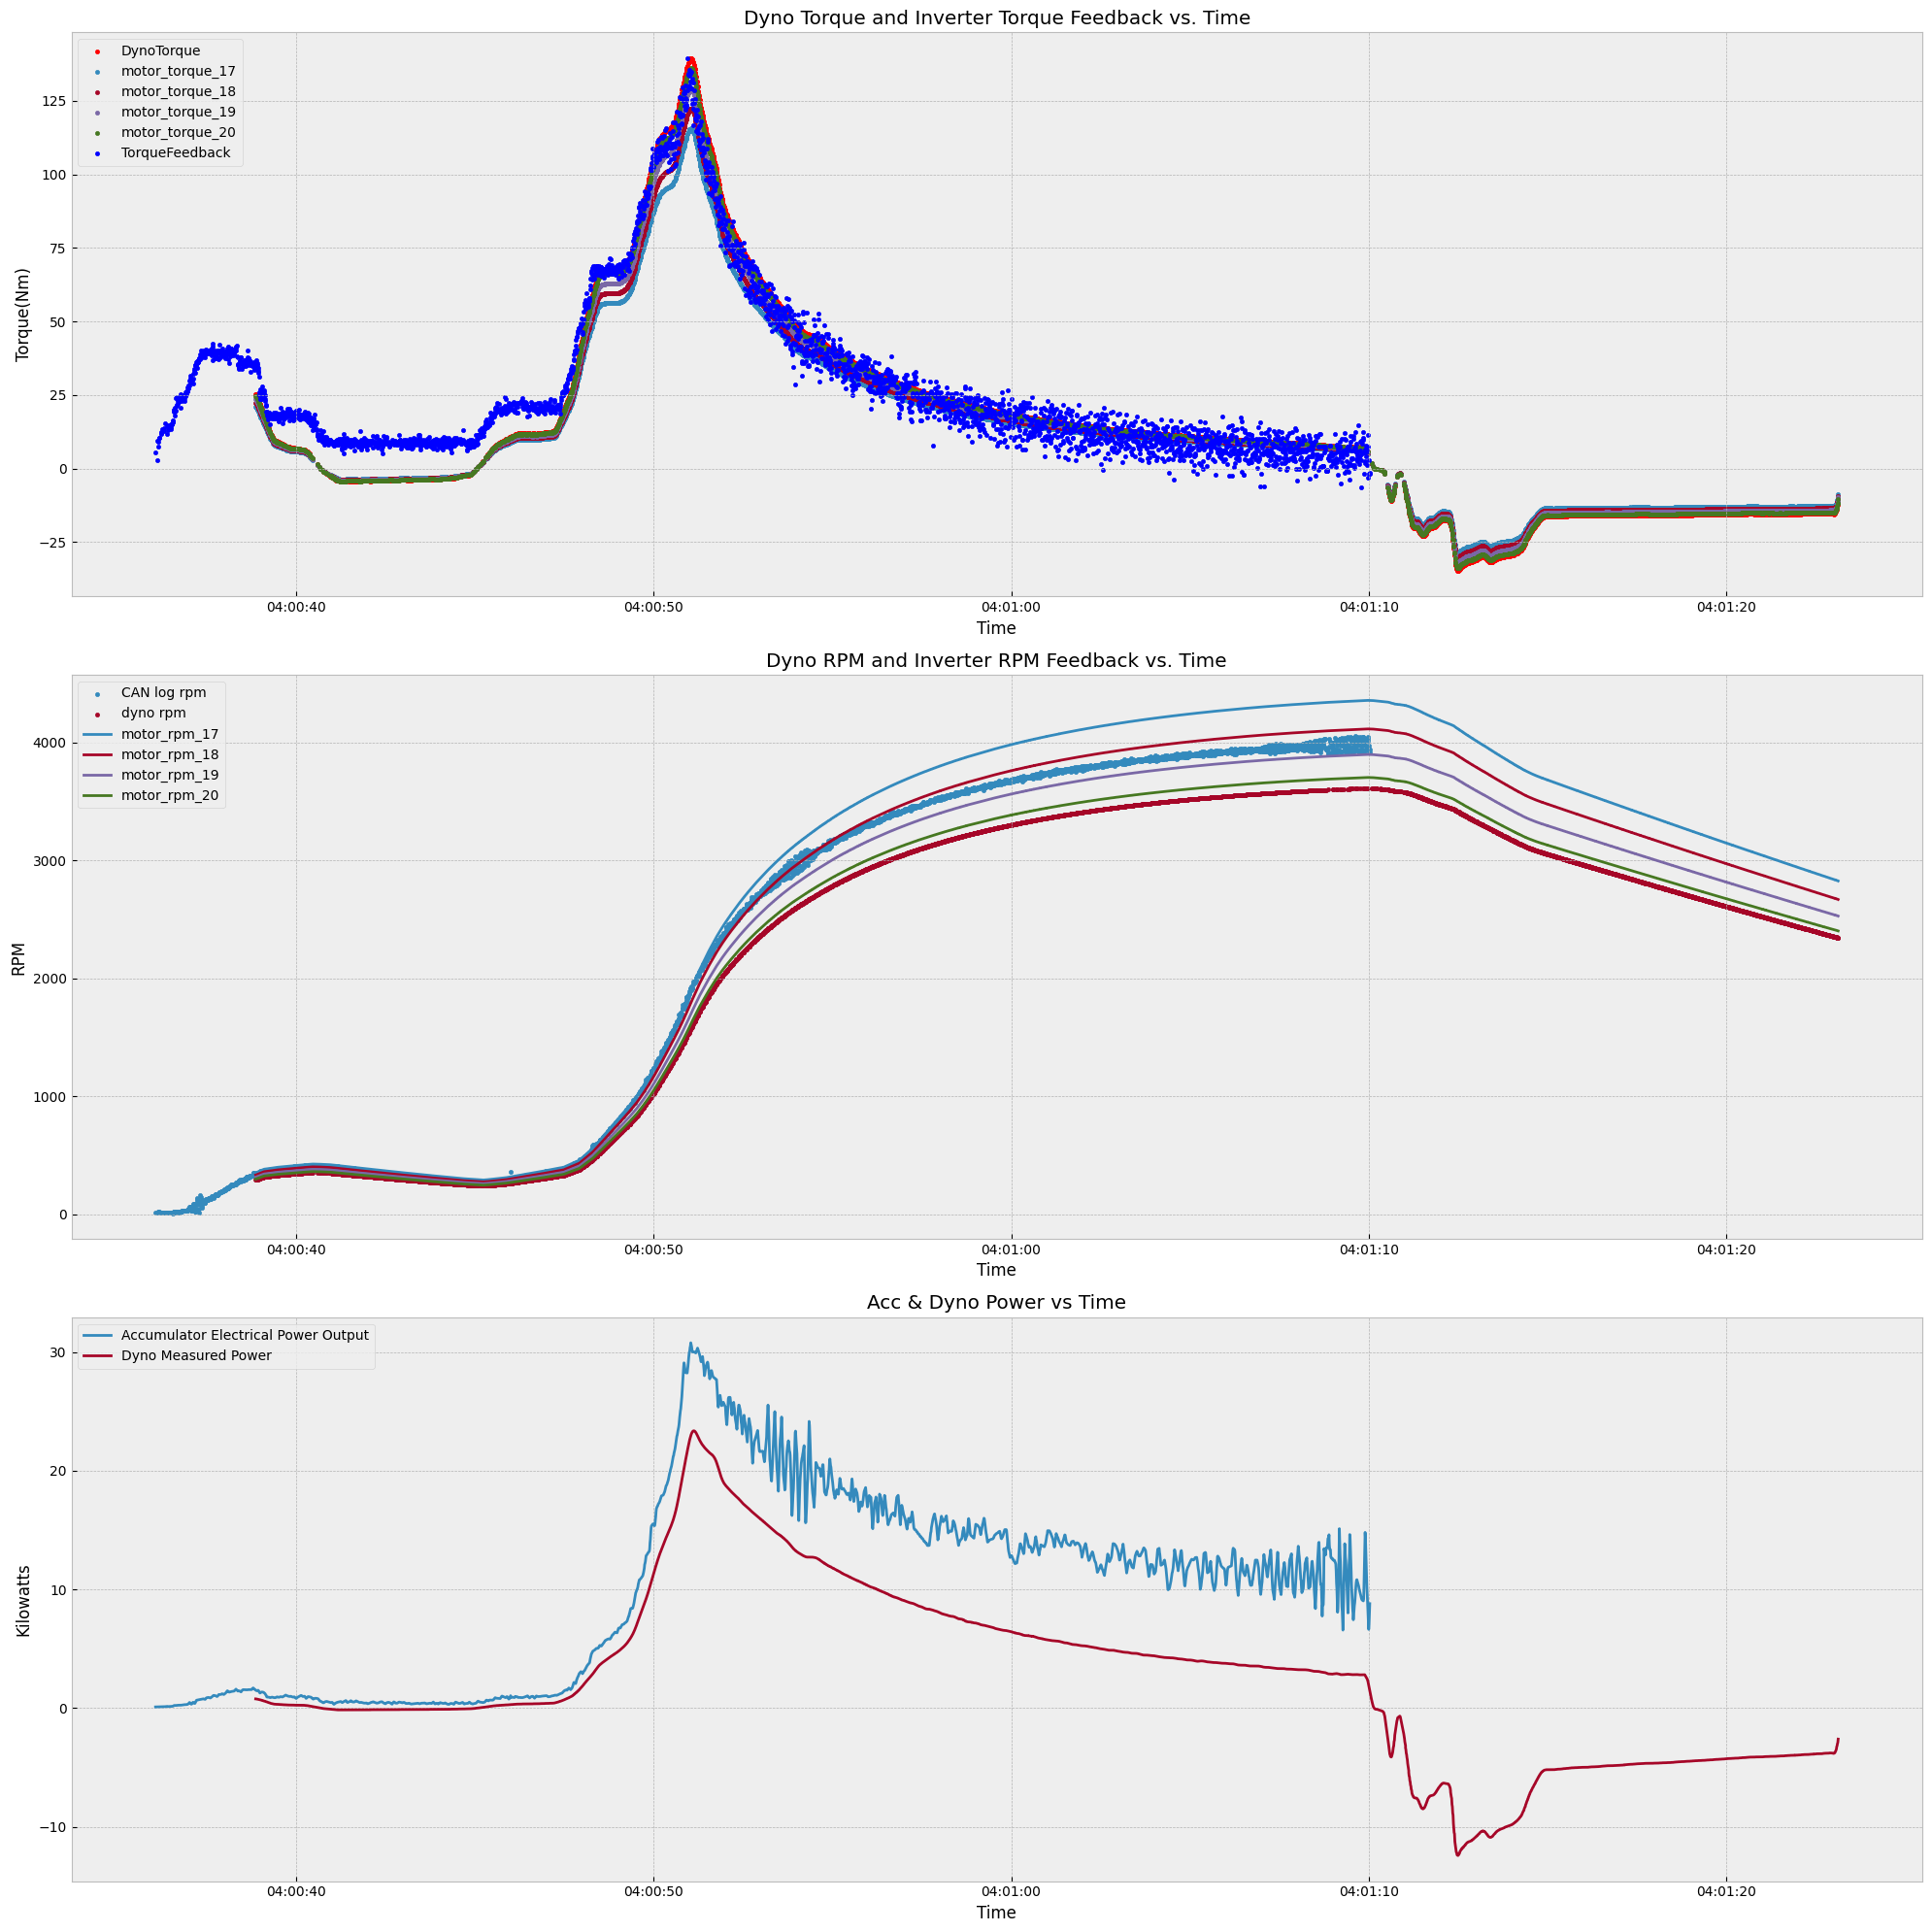

In [112]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
ax1.scatter(dynorun["s"],dynorun['motor_torque'],label="DynoTorque",c="r",marker='.')
for dim in tire_dims:
    ax1.scatter(dynorun["s"],dynorun["motor_torque_"+str(dim)],label="motor_torque_"+str(dim),marker='.')
  
ax1.scatter(vehicle_log.index,vehicle_log['D2_Torque_Feedback'],label="TorqueFeedback",c="b",marker='.')
ax1.title.set_text("Dyno Torque and Inverter Torque Feedback vs. Time")
ax1.set_ylabel("Torque(Nm)")
ax1.set_xlabel("Time")
ax2.scatter(vehicle_log.index,vehicle_log["D2_Motor_Speed"],label="CAN log rpm",marker='.')
ax2.scatter(dynorun["s"],dynorun["motor_rpm"],label="dyno rpm",marker='.')
for dim in tire_dims:
    ax2.plot(dynorun["s"],dynorun["motor_rpm_"+str(dim)],label="motor_rpm_"+str(dim))
  
ax2.title.set_text("Dyno RPM and Inverter RPM Feedback vs. Time")
ax2.set_ylabel("RPM")
ax2.set_xlabel("Time")

ax3.plot(vehicle_log.index,vehicle_log['kw'],label='Accumulator Electrical Power Output')
ax3.plot(dynorun['s'],dynorun['kw'],label='Dyno Measured Power')
ax3.set_ylabel("Kilowatts")
ax3.set_xlabel("Time")
ax3.title.set_text("Acc & Dyno Power vs Time")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc="upper left")
plt.tight_layout()
plt.show()